In [ ]:
from emcfsys.EMCellFiner.models.UNet import UNet
model = UNet()


In [ ]:
import torch
torch.save(model.state_dict(), "model.pt")

In [ ]:
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from skimage.transform import resize
import torch

class ImageMaskDataset(Dataset):
    def __init__(self, images_dir, masks_dir, 
                 image_ext=("png","jpg","jpeg","tif","tiff"),
                 mask_ext="png",
                 target_size=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)

        # 收集所有 image 文件
        imgs = []
        for e in image_ext:
            imgs += list(self.images_dir.glob(f"**/*.{e}"))

        # 只保留有对应 mask 的 image
        self.files = [p for p in imgs if (self.masks_dir / (p.stem + f".{mask_ext}")).exists()]
        self.target_size = target_size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        mask_path = self.masks_dir / f"{img_path.stem}.png"  # mask 必须为 png

        # 读取 image
        im = np.array(Image.open(img_path).convert("L"))  # 转灰度

        # 读取 mask
        m = np.array(Image.open(mask_path).convert("P"))  # 保持离散标签

        # Resize
        if self.target_size is not None and im.shape != self.target_size:
            im = resize(im, self.target_size, preserve_range=True)
            m = resize(m, self.target_size, preserve_range=True, order=0)  # 最近邻插值

        # Normalize image [0,1]
        im = im.astype("float32")
        if im.max() > im.min():
            im = (im - im.min()) / (im.max() - im.min())

        im = im[np.newaxis, ...]  # C,H,W
        m = (m > 0).astype("float32")[np.newaxis, ...]  # binarize mask

        return torch.from_numpy(im), torch.from_numpy(m)


In [ ]:
dataset = ImageMaskDataset(r"D:\napari_EMCF\EMCFsys\emcfsys\image_low",
                           r"D:\napari_EMCF\EMCFsys\emcfsys\label",
                           target_size=(256,256))


print("dataset size: ", dataset.__len__())

In [ ]:
for i in range(len(dataset)):
    img, mask = dataset[i]
    print(img.shape, mask.shape)
    break

In [ ]:
img

In [ ]:
logs = []
epoch_times = []
metrics_all = []
def cb(epoch, batch, n_batches, loss, finished_epoch=False, epoch_time=None, model_dict=None, metrics=None):
    if metrics is not None:
        metrics_all.append(metrics)
    # 保存 batch/epoch 日志
    logs.append((epoch, batch, n_batches, loss, finished_epoch, epoch_time, metrics))
    return logs

In [1]:
from src.emcfsys.EMCellFiner.train import train_loop

logs = []

def my_callback(epoch, batch, n_batches, loss, finished_epoch=False, epoch_time=None, model_dict=None, metrics=None):
    if metrics is not None:
        print(f"[Epoch {epoch}] batch {batch}/{n_batches}, loss={loss}, metric={metrics}")
    # print(f"[Epoch {epoch}] batch {batch}/{n_batches}, loss={loss}, metric={metrics}")
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
train_loop(images_dir=r"D:\napari_EMCF\EMCFsys\emcfsys\image", 
        masks_dir=r"D:\napari_EMCF\EMCFsys\emcfsys\label", 
        save_path= r"D:\napari_EMCF\EMCFsys\emcfsys\save",
        pretrained_model=None,#r"D:\napari_EMCF\EMCFsys\emcfsys\save\best_model_epoch_21.pth",
        lr=1e-3, 
        batch_size=4, 
        epochs=100, 
        device=None,
        callback=my_callback, 
        target_size=(512, 512), 
        in_channels=3, 
        classes_num=2, 
        ignore_index=-1)

New best model found at epoch 1! IoU=0.4591
[Epoch 1] batch 0/37, loss=0.8416530795999475, metric={'IoU': 0.459064982227377, 'Accuracy': 0.918129964454754, 'F1': 0.4785915484299531}
[Epoch 2] batch 0/37, loss=0.7441166059390919, metric={'IoU': 0.4582360112989271, 'Accuracy': 0.9164720225978542, 'F1': 0.4781405345813648}
[Epoch 3] batch 0/37, loss=0.7410993656596622, metric={'IoU': 0.4578459931386484, 'Accuracy': 0.9156919862772968, 'F1': 0.47793159935925456}
[Epoch 4] batch 0/37, loss=0.7420041110064532, metric={'IoU': 0.45875768806483297, 'Accuracy': 0.9175153777406022, 'F1': 0.4784574573104446}
[Epoch 5] batch 0/37, loss=0.7428856169855272, metric={'IoU': 0.4580460585452415, 'Accuracy': 0.916092117090483, 'F1': 0.4780368200830511}
[Epoch 6] batch 0/37, loss=0.7394474664249936, metric={'IoU': 0.4589225239044911, 'Accuracy': 0.9178450478089822, 'F1': 0.4785314202308655}
New best model found at epoch 7! IoU=0.4597
[Epoch 7] batch 0/37, loss=0.7309738429816993, metric={'IoU': 0.459748620

'D:\\napari_EMCF\\EMCFsys\\emcfsys\\save'

C:\Users\YZY\AppData\Local\Temp\ipykernel_32316\1606853735.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r"D:\napari_EMCF\EMCFsys\emcfsys\save\best

(1024, 1024)


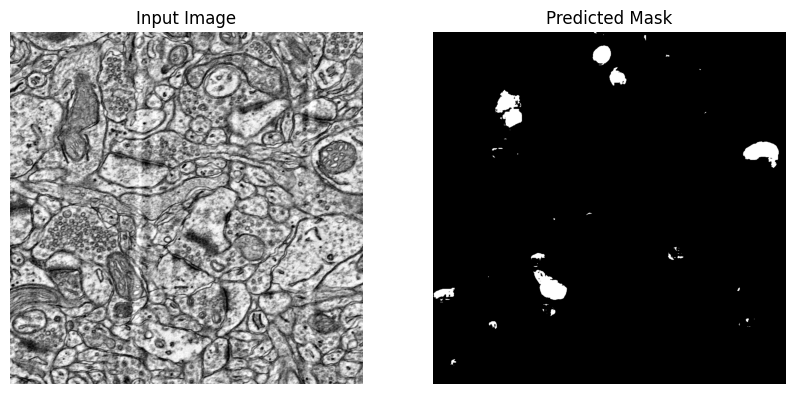

In [ ]:
# test_inference.py
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.emcfsys.EMCellFiner.inference import infer_numpy, prepare_image
from emcfsys.EMCellFiner.models.UNet import UNet
from PIL import Image
def test_inference_single_image():
    # -------------------------
    # 1. 准备模型
    # -------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load(r"D:\napari_EMCF\EMCFsys\emcfsys\save\best_model_epoch89_IoU=0.8016.pth", map_location=device)#UNet(in_channels=3, out_channels=2)  # 修改通道数和类别数
    model.to(device)
    model.eval()  # 测试模式

    # -------------------------
    # 2. 准备测试图像
    # -------------------------
    img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_zZAXMi5nsjCDBo8m.tif"
    img = Image.open(img_path).convert("RGB")
    img = np.array(img)


    # -------------------------
    # 3. 运行推理
    # -------------------------
    mask = infer_numpy(model, img, device=device, threshold=0.5)
    print(mask.shape)
 
    # -------------------------
    # 4. 可视化
    # -------------------------
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

if __name__ == "__main__":
    test_inference_single_image()


In [4]:
mask

NameError: name 'mask' is not defined

In [ ]:
import torch
torch.load(r"D:\napari_EMCF\EMCFsys\emcfsys\save\best_model_epoch_1.pth")

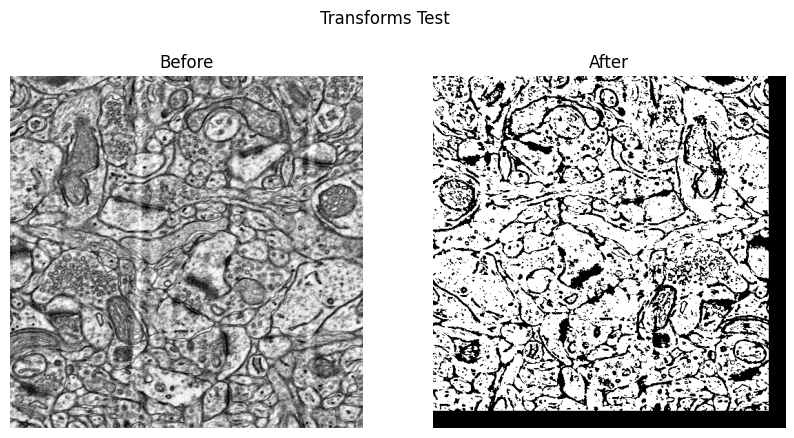

1
[0 1]


In [1]:
from src.emcfsys.EMCellFiner.transforms import (
    Compose, LoadImage, LoadMask, PhotometricDistortion, AlbumentationsTransform,
    RandomErasing, RandomScale, Pad, ToTensor,  RandomCrop, Resize, Normalize, RandomFlip
)
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
import numpy as np
def visualize(before_img, after_img, title=""):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(before_img)
    plt.title("Before")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(after_img)
    plt.title("After")
    plt.axis("off")

    plt.suptitle(title)
    plt.show()

def main():

    # -------------------------
    # 输入路径，请自行修改
    # -------------------------
    img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_zZAXMi5nsjCDBo8m.tif"
    mask_path = r"D:\napari_EMCF\EMCFsys\emcfsys\label\Bock2011_2951_zZAXMi5nsjCDBo8m.png"

    # 用 OpenCV 加载，方便可视化
    before_img = Image.open(img_path).convert("RGB")
    before_img = np.array(before_img)

    # 反归一化，用于可视化
    mean = np.array([123,123.,123.])
    std  = np.array([58.,58.,58.])

    # -------------------------
    # 构建增强 pipeline
    # -------------------------
    pipeline = Compose([
        LoadImage(),                              # 读取图像
        LoadMask(),                               # 读取 mask
        Resize((512, 512)),                       # 固定缩放
        PhotometricDistortion(),                  # 颜色扰动（mmseg）
        AlbumentationsTransform(A.HorizontalFlip(p=.5)),  # Albumentations
        RandomScale((0.8, 1.4)),                  # 随机缩放
        RandomCrop((512, 512)), 
        Pad((512, 512)),                          # pad 到指定 size
        RandomErasing(prob=0.5),                  # cutout
        Normalize(mean=mean, std=std),# normalize
        ToTensor(),                               # 转为 tensor 风格 (C,H,W)
    ])

    # -------------------------
    # 执行增强
    # -------------------------
    results = {"img_path": img_path, "mask_path": mask_path}
    processed = pipeline(results)



    after_img = processed["img"].cpu().numpy().transpose(1,2,0)  # C,H,W -> H,W,C
    mask = processed["mask"].cpu().numpy()
    # print(after_img)
    after_img = ((after_img*255 * std + mean)).clip(0,255).astype(np.uint8)
    # print(after_img)
    visualize(before_img, after_img, title="Transforms Test")
    print(mask.max())
    print(np.unique(mask))
main()

In [6]:
mask_path = r"D:\napari_EMCF\EMCFsys\emcfsys\label\Bock2011_2951_zZAXMi5nsjCDBo8m.png"
from PIL import Image
import numpy as np
# Image.open(mask_path).convert("P")
mask = np.array(Image.open(mask_path).convert("P").resize((2222,512), Image.NEAREST))

In [7]:
mask.max()

np.uint8(1)